# Step 1 - Data Acquisition & Preparing the Dataset

In [4]:
from pathlib import Path
print("当前工作目录：", Path.cwd())
print("当前目录下的文件：")
for f in Path.cwd().iterdir():
    print(f)

当前工作目录： /drive/notebooks
当前目录下的文件：
/drive/notebooks/Project_1.ipynb
/drive/notebooks/listings.txt
/drive/notebooks/sqlite.ipynb
/drive/notebooks/r.ipynb
/drive/notebooks/Intro.ipynb
/drive/notebooks/cpp-smallpt.ipynb
/drive/notebooks/cpp-third-party-libs.ipynb
/drive/notebooks/cpp.ipynb
/drive/notebooks/Lorenz.ipynb


In [3]:
from pathlib import Path
print("当前工作目录：", Path.cwd())

当前工作目录： /drive/notebooks


In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import ast

# Path to the raw data (CSV file)
csv_file = Path("listings.txt")
df = pd.read_csv(csv_file, low_memory=False)

# Check dataset size (rows, columns)
df.shape

# Overview of columns, data types, and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36261 entries, 0 to 36260
Data columns (total 85 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36261 non-null  int64  
 1   listing_url                                   36261 non-null  object 
 2   scrape_id                                     36261 non-null  int64  
 3   last_scraped                                  36261 non-null  object 
 4   source                                        36261 non-null  object 
 5   name                                          36259 non-null  object 
 6   description                                   34893 non-null  object 
 7   neighborhood_overview                         18130 non-null  object 
 8   picture_url                                   36261 non-null  object 
 9   host_id                                       36261 non-null 

# Step 2 - Data Cleaning and Handling Inconsistencies

Step 2 of the project was done by Maya.

## Detect and rectify data type inconsistencies

In [6]:
# Work on a copy so the original df stays untouched
df0 = df.copy()

#### Convert dates from str to datetime

In [7]:
# Columns that should be dates
date_cols = ["last_scraped", "host_since", "calendar_last_scraped", "first_review", "last_review"]

# Convert date columns from string -> datetime (invalid parses become NaT)
for c in date_cols:
    if c in df0.columns:
        df0[c] = pd.to_datetime(df0[c], errors="coerce")

# Confirm new dtypes
df0[date_cols].dtypes

last_scraped             datetime64[ns]
host_since               datetime64[ns]
calendar_last_scraped    datetime64[ns]
first_review             datetime64[ns]
last_review              datetime64[ns]
dtype: object

#### Convert "t/f" strings into booleans

In [8]:
# Convert consistent 't'/'f' string columns to boolean
bool_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
    "has_availability",
]

# Fix boolean columns safely: normalize strings first, then map
for c in bool_cols:
    if c in df0.columns:
        df0[c] = (
            df0[c]
            .astype(str)          # ensure string
            .str.strip()          # remove whitespace
            .str.lower()          # normalize case
            .map({"t": True, "f": False})
            .astype("boolean")     
        )

# Confirm new dtypes and values
df0[bool_cols].dtypes

host_is_superhost         boolean
host_has_profile_pic      boolean
host_identity_verified    boolean
instant_bookable          boolean
has_availability          boolean
dtype: object

#### Convert numeric strings into float

In [9]:
# Convert percent strings like "95%" -> 0.95
pct_cols = ["host_response_rate", "host_acceptance_rate"]

for c in pct_cols:
    s = df0[c].astype("string").str.strip()          # clean whitespace
    s = s.str.replace("%", "", regex=False)          # remove % sign
    df0[c] = pd.to_numeric(s, errors="coerce") / 100

# Confirm new dtypes and values
df0[pct_cols].dtypes

host_response_rate      Float64
host_acceptance_rate    Float64
dtype: object

#### Convert all IDs into strings

In [10]:
id_cols = [
    "id",
    "host_id",
    "host_profile_id",
    "license"
]

for c in id_cols:
    if c in df0.columns:
        df0[c] = df0[c].astype("string")

# Confirm new dtypes and values
df0[id_cols].dtypes

id                 string[python]
host_id            string[python]
host_profile_id    string[python]
license            string[python]
dtype: object

#### Convert lists encoded as string

In [11]:
def parse_amenities(x):
    # If missing, return empty list + flag
    if pd.isna(x):
        return [], False

    x = str(x).strip()

    if x == "[]":
        return [], True

    # Try JSON parsing
    try:
        out = json.loads(x)
        return out if isinstance(out, list) else [], True
    except Exception:
        pass

    # Fallback: Python literal list parsing
    try:
        out = ast.literal_eval(x)
        return out if isinstance(out, list) else [], True
    except Exception:
        return [], False

# Apply parsing and keep a success flag so we can audit parsing quality
parsed = df0["amenities"].apply(parse_amenities)
df0["amenities_list"] = parsed.apply(lambda t: t[0])

# Clean each amenity string inside the list
def clean_amenity_list(lst):
    cleaned = []
    for a in lst:
        a = str(a).strip()              # remove leading/trailing spaces
        a = " ".join(a.split())         # collapse repeated whitespace
        a = a.lower()                   # standard casing
        if a != "":
            cleaned.append(a)

    # Dedupe within a listing (keeps order)
    seen = set()
    deduped = []
    for a in cleaned:
        if a not in seen:
            seen.add(a)
            deduped.append(a)

    return deduped

df0["amenities_list"] = df0["amenities_list"].apply(clean_amenity_list)

# Count amenities per listing
df0["amenities_count"] = df0["amenities_list"].apply(len).astype("int64")

In [12]:
# Same process for host_verifications
df0["host_verifications"] = df0["host_verifications"].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else x
)

#### Remove columns that are completely empty

In [13]:
# Identify columns with all missing values
empty_cols = df.columns[df.isna().all()].tolist()
empty_cols

# Remove empty columns
df0 = df0.drop(columns=empty_cols)

#### Remove zero variability columns

In [14]:
non_list_cols = [
    c for c in df0.columns
    if not df0[c].dropna().apply(lambda x: isinstance(x, list)).any()
]

zero_var_cols = [c for c in non_list_cols if df0[c].nunique(dropna=True) <= 1]

# Remove
df0 = df0.drop(columns=zero_var_cols)


## Ensure uniform formatting across variables

#### Define feature groups

In [15]:
# 1) URL-like columns (don’t lowercase)
url_cols = [
    "listing_url", "picture_url", "host_url",
    "host_profile_url", "host_thumbnail_url", "host_picture_url"
]

# 2) Long free-text columns (don’t lowercase)
long_text_cols = ["name", "description", "neighborhood_overview", "host_about"]

# 3) Category-like columns (safe to lowercase)
cat_cols = [
    "source", "host_location", "host_response_time", "host_neighbourhood",
    "neighbourhood", "neighbourhood_cleansed", "neighbourhood_group_cleansed",
    "property_type", "room_type", "license"
]

# 4) Text columns (clear whitespace)
whitespace_cols = [
    "listing_url",
    "source",
    "name",
    "description",
    "neighborhood_overview",
    "picture_url",
    "host_url",
    "host_profile_url",
    "host_name",
    "host_location",
    "host_about",
    "host_response_time",
    "host_neighbourhood",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
    "bathrooms_text",
    "license",
]

#### Strip + normalize whitespace for all string columns

In [16]:
# Clean whitespace for all string columns
for c in whitespace_cols:
    df0[c] = (
        df0[c]
        .astype("string")
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )

In [17]:
# Lowercase category-like columns only
for c in cat_cols:
    if c in df0.columns:
        df0[c] = df0[c].astype("string").str.lower()

#### Group all missing strings

In [18]:
missing_like = {"n/a", "na", "none", "nan", "null", "unknown", ""}

for c in cat_cols + long_text_cols:
    if c in df0.columns:
        s = df0[c].astype("string")
        df0[c] = s.mask(s.str.lower().isin(missing_like))

#### Parse categorical data into numeric values

In [19]:
# bathroom_text
bt = df0["bathrooms_text"]

num = pd.to_numeric(
    bt.str.extract(r"(\d+(\.\d+)?)")[0],
    errors="coerce"
)

half_only = bt.str.fullmatch(r"(a\s+)?half[-\s]?bath(s)?", na=False)

df0["bathroom_shared"] = bt.str.contains("shared", na=False)
df0["bathroom_private"] = bt.str.contains("private", na=False)

In [20]:
# host_response_time

hrt = df0["host_response_time"]

response_time_map = {
    "within an hour": 1,
    "within a few hours": 2,
    "within a day": 3,
    "a few days or more": 4
}

df0["host_response_time_num"] = df0["host_response_time"].map(response_time_map)

# Handle missing values
df0["host_response_time_num"] = df0["host_response_time_num"].fillna(5)

#### Drop irrelevant features

In [21]:
relevant_features = [
    # Identifiers
    "id",
    "host_id",

    # Listing metadata
    "name",

    # Host experience & tenure
    "hosts_time_as_user_years",
    "hosts_time_as_host_years",

    # Host responsiveness & quality
    "host_response_time_num",
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "host_verifications",

    # Host scale
    "host_listings_count",
    "host_total_listings_count",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",

    # Listing location
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "latitude",
    "longitude",

    # Property & capacity
    "property_type",
    "room_type",
    "accommodates",
    "bedrooms",
    "beds",

    # Bathrooms
    "bathrooms",
    "bathroom_shared",
    "bathroom_private",

    # Stay constraints
    "minimum_nights",
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",

    # Availability & demand
    "has_availability",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "availability_eoy",
    "estimated_occupancy_l365d",

    # Reviews & ratings
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "number_of_reviews_ly",
    "reviews_per_month",
    "first_review",
    "last_review",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",

    # Amenities
    "amenities_list",
    "amenities_count",

    # Booking behavior
    "instant_bookable",
]

df_eda = df0[relevant_features].copy()

## Address duplicate data entries

#### Check for duplicate IDs

In [22]:
df_eda["id"].duplicated().sum()

np.int64(0)

In [23]:
# Check for full row duplicates
df_dup = df0.copy()

for col in df_dup.columns:
    if df_dup[col].apply(lambda x: isinstance(x, list)).any():
        df_dup[col] = df_dup[col].apply(
            lambda x: tuple(sorted(x)) if isinstance(x, list) else x
        )

full_duplicates = df_dup.duplicated().sum()
print("Full row duplicates:", full_duplicates)

Full row duplicates: 0


#### Check for near duplicates

In [24]:
near_duplicates = df0.duplicated(
    subset=["host_id", "name", "latitude", "longitude"]
).sum()

print("Near duplicates:", near_duplicates)

Near duplicates: 375


In [25]:
# Inspect and handle near duplicates
key_cols = ["host_id", "name", "latitude", "longitude"]

df0["last_review"] = pd.to_datetime(df0["last_review"], errors="coerce")

# Helper: count missing per row (lower is better)
df0["_missing_count"] = df0.isna().sum(axis=1)

# Sort so the "best" row appears first in each near-duplicate group
df0 = df0.sort_values(
    by=["number_of_reviews", "last_review", "_missing_count"],
    ascending=[False, False, True]
)

before = len(df0)

# Keep the best row per group
df0 = df0.drop_duplicates(subset=key_cols, keep="first")

after = len(df0)

df0 = df0.drop(columns=["_missing_count"])

print("Removed near-duplicate rows:", before - after)

Removed near-duplicate rows: 375


In [26]:
near_duplicates_after = df0.duplicated(subset=key_cols).sum()
print("Near duplicates after:", near_duplicates_after)

Near duplicates after: 0


## Identify and handle outliers

In [27]:
# Select all numeric columns
results = []

for col in df_eda.select_dtypes(include="number").columns:
    max_val = df_eda[col].max()
    p99 = df_eda[col].quantile(0.99)
    
    # Avoid division by zero
    ratio = max_val / p99 if p99 != 0 else np.nan
    
    results.append({
        "column": col,
        "max": max_val,
        "p99": p99,
        "max_to_p99_ratio": ratio,
        "flagged_over_10x": ratio > 10 if pd.notna(ratio) else False
    })

outlier_check = pd.DataFrame(results)

flagged = outlier_check[outlier_check["flagged_over_10x"] == True] \
    .sort_values("max_to_p99_ratio", ascending=False)

print("Flagged columns (max > 10x p99):", flagged.shape[0])
display(flagged.head(15))

Flagged columns (max > 10x p99): 13


,column,max,p99,max_to_p99_ratio,flagged_over_10x
18,maximum_nights,2.147484e+09,1125.0000,1.908874e+06,True
21,minimum_maximum_nights,2.147484e+09,1125.0000,1.908874e+06,True
22,maximum_maximum_nights,2.147484e+09,1125.0000,1.908874e+06,True
24,maximum_nights_avg_ntm,2.147484e+09,1125.0000,1.908874e+06,True
10,calculated_host_listings_count_shared_rooms,3.400000e+01,1.0000,3.400000e+01,True
34,number_of_reviews_ly,1.797000e+03,57.0000,3.152632e+01,True
32,number_of_reviews_ltm,1.565000e+03,59.0000,2.652542e+01,True
35,reviews_per_month,1.203700e+02,6.0389,1.993244e+01,True
33,number_of_reviews_l30d,7.400000e+01,5.0000,1.480000e+01,True
31,number_of_reviews,3.920000e+03,296.4000,1.322537e+01,True


#### Cap true data outliers 

In [28]:
night_cols = [
    "maximum_nights",
    "maximum_maximum_nights",
    "minimum_maximum_nights",
    "maximum_nights_avg_ntm"
]

for col in night_cols:
    df_eda.loc[df_eda[col] > 10000, col] = np.nan

#### Check for unrealistic negative values

In [29]:
num_cols = df_eda.select_dtypes(include="number").columns

neg_min = []
for col in num_cols:
    mn = df_eda[col].min()
    if mn < 0:
        neg_min.append([col, mn])

neg_min_df = pd.DataFrame(neg_min, columns=["column", "min_value"]).sort_values("min_value")
neg_min_df

,column,min_value
0,longitude,-74.251907


#### Verify explicit domain rules

In [30]:
checks = {
    "accommodates": (df_eda["accommodates"] < 1),
    "minimum_nights": (df_eda["minimum_nights"] < 1),
    "availability_365": (df_eda["availability_365"] < 0) | (df_eda["availability_365"] > 365),
    "host_response_rate": (df_eda["host_response_rate"] < 0) | (df_eda["host_response_rate"] > 1),
    "host_acceptance_rate": (df_eda["host_acceptance_rate"] < 0) | (df_eda["host_acceptance_rate"] > 1),
}

for name, mask in checks.items():
    if name in df_eda.columns:
        print(name, mask.sum())

accommodates 0
minimum_nights 0
availability_365 0
host_response_rate 0
host_acceptance_rate 0


In [31]:
more_checks = {
    "availability_30_range": (df_eda["availability_30"] < 0) | (df_eda["availability_30"] > 30),
    "availability_60_range": (df_eda["availability_60"] < 0) | (df_eda["availability_60"] > 60),
    "availability_90_range": (df_eda["availability_90"] < 0) | (df_eda["availability_90"] > 90),

    "beds_nonnegative": (df_eda["beds"] < 0) if "beds" in df_eda.columns else False,
    "bedrooms_nonnegative": (df_eda["bedrooms"] < 0) if "bedrooms" in df_eda.columns else False,
    "bathrooms_nonnegative": (df_eda["bathrooms"] < 0) if "bathrooms" in df_eda.columns else False,

    "review_scores_low": (df_eda["review_scores_rating"] < 0) if "review_scores_rating" in df_eda.columns else False,
    "review_scores_high": (df_eda["review_scores_rating"] > 5) if "review_scores_rating" in df_eda.columns else False,
}

for name, mask in more_checks.items():
    if isinstance(mask, bool):
        continue
    print(name, int(mask.sum()))

availability_30_range 0
availability_60_range 0
availability_90_range 0
beds_nonnegative 0
bedrooms_nonnegative 0
bathrooms_nonnegative 0
review_scores_low 0
review_scores_high 0


## Identify and handle missing values

#### Find missing values

In [32]:
missing_counts = df_eda.isna().sum()
missing_percent = (missing_counts / len(df_eda)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

missing_df = missing_df[missing_df["missing_count"] > 0]
missing_df.sort_values("missing_percent", ascending=False)

,missing_count,missing_percent
host_response_rate,15173,41.843854
beds,14891,41.066159
bathrooms,14806,40.831748
host_acceptance_rate,14741,40.652492
review_scores_location,11367,31.347729
review_scores_value,11366,31.344971
review_scores_checkin,11364,31.339456
review_scores_accuracy,11360,31.328424
review_scores_communication,11356,31.317393
review_scores_cleanliness,11351,31.303604


#### Drop rows with very low missing precentage

In [33]:
tiny_cols = [
    "maximum_maximum_nights",
    "maximum_nights_avg_ntm",
    "host_identity_verified",
    "host_verifications",
    "host_has_profile_pic",
    "host_total_listings_count",
    "host_listings_count",
    "minimum_maximum_nights",
    "maximum_minimum_nights",
    "minimum_minimum_nights",
    "name",
    "maximum_nights"
]

tiny_cols = [c for c in tiny_cols if c in df_eda.columns]

df_eda = df_eda.dropna(subset=tiny_cols)

In [34]:
# Find listings that have no review data
review_cols = [
    "review_scores_rating",
    "review_scores_cleanliness",
    "review_scores_value",
    "review_scores_location",
    "review_scores_checkin",
    "review_scores_accuracy",
    "review_scores_communication",
    "reviews_per_month",
    "first_review",
    "last_review"
]

review_cols = [c for c in review_cols if c in df_eda.columns]

# Count rows where ALL review columns are missing
all_reviews_missing = df_eda[review_cols].isna().all(axis=1).sum()

print("Rows with all review data missing:", all_reviews_missing)

# Create a new has_reviews feature
df_eda["has_reviews"] = (~df_eda["review_scores_rating"].isna()).astype(int)

# Set reviews_per_month to 0 for no review listings
df_eda.loc[df_eda["has_reviews"] == 0, "reviews_per_month"] = 0

Rows with all review data missing: 11342


In [35]:
# Create missing flags for host columns
host_cols = [
    "host_response_rate",
    "host_acceptance_rate"
]

host_cols = [c for c in host_cols if c in df_eda.columns]

for col in host_cols:
    df_eda[col + "_missing"] = df_eda[col].isna().astype(int)

# Fill numeric host metrics with median
for col in ["host_response_rate", "host_acceptance_rate"]:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors="coerce")
        df_eda[col] = df_eda[col].fillna(df_eda[col].median())

#### Use KNN for missing beds/bedrooms/bathrooms

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_eda["room_type_encoded"] = le.fit_transform(df_eda["room_type"])

knn_cols = [
    "beds",
    "bathrooms",
    "bedrooms",
    "accommodates",
    "amenities_count",
    "room_type_encoded"
]

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

scaler = StandardScaler()
scaled = scaler.fit_transform(df_eda[knn_cols])

imputer = KNNImputer(n_neighbors=5)
imputed_scaled = imputer.fit_transform(scaled)

imputed = scaler.inverse_transform(imputed_scaled)
df_eda[knn_cols] = imputed

df_eda["beds"] = df_eda["beds"].round().astype(int)
df_eda["bedrooms"] = df_eda["bedrooms"].round().astype(int)
df_eda["bathrooms"] = df_eda["bathrooms"].round(1)  # bathrooms can be 1.5

#### Median-impute host time columns

In [37]:
df_eda["hosts_time_as_host_years"] = df_eda["hosts_time_as_host_years"].fillna(
    df_eda["hosts_time_as_host_years"].median()
)

df_eda["hosts_time_as_user_years"] = df_eda["hosts_time_as_user_years"].fillna(
    df_eda["hosts_time_as_user_years"].median()
)

#### Fill 'unkown' has_availability rows

In [38]:
# Convert to integer categories
df_eda["has_availability"] = df_eda["has_availability"].map({
    True: 1,
    False: 0
})

df_eda["has_availability"] = df_eda["has_availability"].fillna(2)

In [39]:
missing_summary = df_eda.isna().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]

missing_summary

review_scores_location         11360
review_scores_value            11359
review_scores_checkin          11357
review_scores_accuracy         11353
review_scores_communication    11349
review_scores_cleanliness      11344
last_review                    11342
review_scores_rating           11342
first_review                   11342
dtype: int64

In [40]:
print("Original shape:", df.shape)
print("Final shape:", df_eda.shape)

Original shape: (36261, 85)
Final shape: (36227, 66)


### Handling missing values - summary:

Missing values have been addressed. Listings without review data are not missing at random; they simply have no reviews. A has_reviews indicator was created to distinguish these listings, and reviews_per_month was set to 0 where applicable.

Host response metrics include missing flags to preserve information about unavailable response history before imputation. Property characteristics such as beds, bedrooms, and bathrooms were imputed using KNN based on related features. Small amounts of random missing data were either imputed or the corresponding rows were removed.

Models (using df_eda) should include has_reviews if using review-related features.

# Step 3 - EDA

Step 3 of the project was done by Yuxuan.

In [44]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# 设置全局绘图参数
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [45]:
# 1. 数据概览
print("dataset shape:", df_eda.shape)
print("\nfirst 5 rows:\n", df_eda.head())
print("\ncolnames:\n", df_eda.columns.tolist())
print("\ndatatype counts:\n", df_eda.dtypes.value_counts())

dataset shape: (36227, 66)

first 5 rows:
      id host_id                                               name  \
0  2539    2787    Superfast Wi-Fi. Clean & quiet home by the park   
1  2595    2845  Skylit Studio Oasis | Midtown Manhattan Sanctuary   
2  6848   15991                   Only 2 stops to Manhattan studio   
3  6872   16104  Uptown Sanctuary w/ Private Bath (Month to Month)   
4  6990   16800                            UES Beautiful Blue Room   

   hosts_time_as_user_years  hosts_time_as_host_years  host_response_time_num  \
0                      17.0                      14.0                     1.0   
1                      17.0                      14.0                     3.0   
2                      16.0                      14.0                     1.0   
3                      16.0                      14.0                     3.0   
4                      16.0                      14.0                     1.0   

   host_response_rate  host_acceptance_rate  host

In [46]:
# 2. descirptive stats
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
print("\ndescirptive stats:\n", df_eda[num_cols].describe().T)


descirptive stats:
                                                 count        mean  \
hosts_time_as_user_years                      36227.0    8.203301   
hosts_time_as_host_years                      36227.0    6.693902   
host_response_time_num                        36227.0    3.003506   
host_response_rate                            36227.0    0.948881   
host_acceptance_rate                          36227.0    0.814215   
host_listings_count                           36227.0  275.205896   
host_total_listings_count                     36227.0  374.333149   
calculated_host_listings_count                36227.0   68.393132   
calculated_host_listings_count_entire_homes   36227.0   51.394126   
calculated_host_listings_count_private_rooms  36227.0   16.253513   
calculated_host_listings_count_shared_rooms   36227.0    0.093135   
latitude                                      36227.0   40.728375   
longitude                                     36227.0  -73.947372   
accommodates 

In [47]:
# 3. na values analysis
missing = df_eda.isna().sum()
missing_pct = (missing / len(df_eda)) * 100
missing_df = pd.DataFrame({'missing number': missing, 'missing percentage': missing_pct})
missing_df = missing_df[missing_df['missing number'] > 0].sort_values('missing percentage', ascending=False)
print("\nna values:\n", missing_df)


na values:
                              missing number  missing percentage
review_scores_location                11360           31.357827
review_scores_value                   11359           31.355067
review_scores_checkin                 11357           31.349546
review_scores_accuracy                11353           31.338504
review_scores_communication           11349           31.327463
review_scores_cleanliness             11344           31.313661
first_review                          11342           31.308140
last_review                           11342           31.308140
review_scores_rating                  11342           31.308140


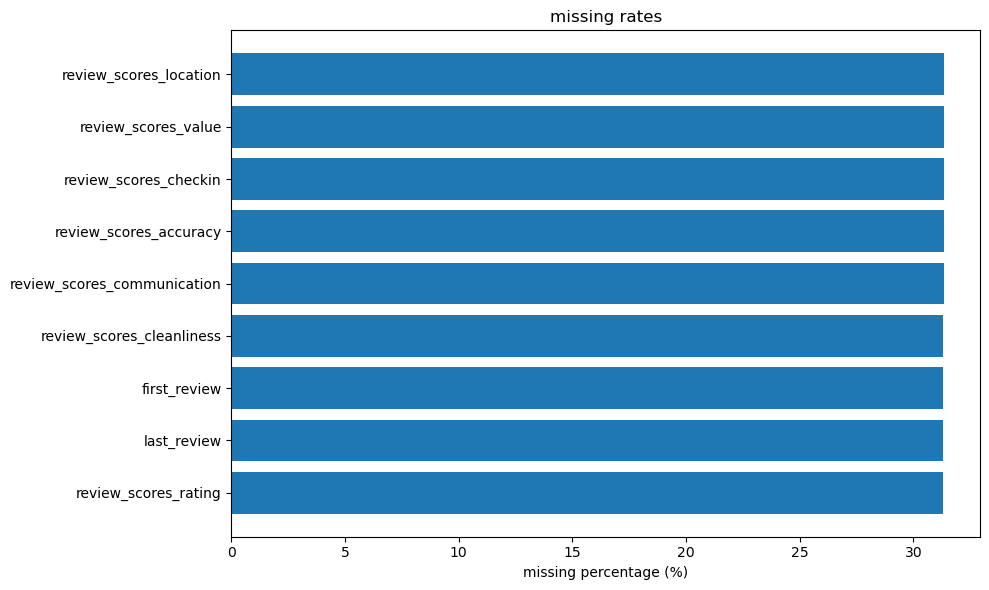

In [48]:
# barchart of missing values（matplotlib）
if not missing_df.empty:
    plt.figure(figsize=(10, max(6, len(missing_df)*0.3)))
    plt.barh(missing_df.index, missing_df['missing percentage'])
    plt.xlabel('missing percentage (%)')
    plt.title('missing rates')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

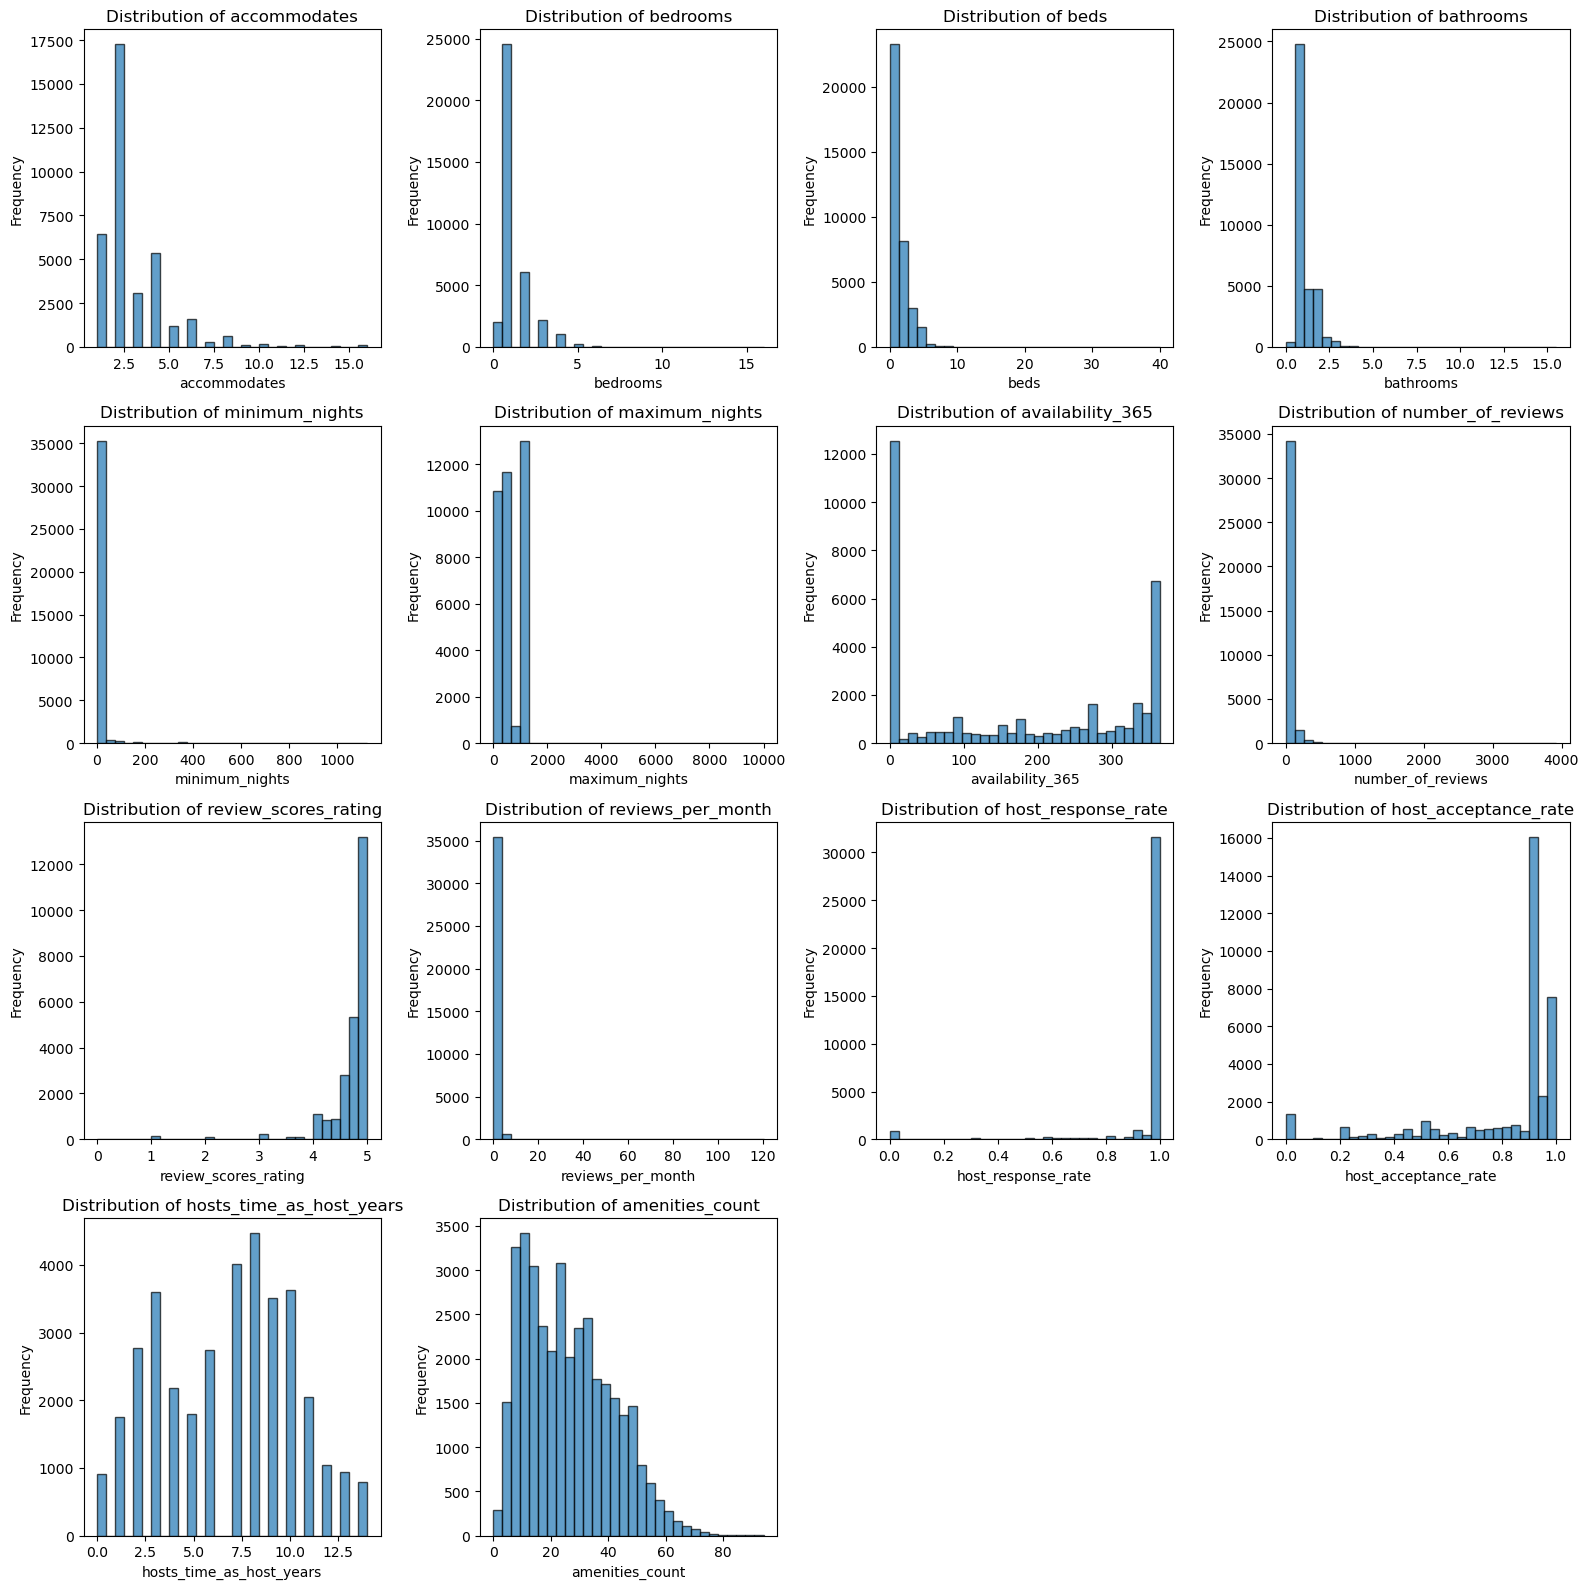

In [49]:
# 4. plottings
plot_num_cols = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 
                 'minimum_nights', 'maximum_nights', 
                 'availability_365', 'number_of_reviews', 
                 'review_scores_rating', 'reviews_per_month',
                 'host_response_rate', 'host_acceptance_rate',
                 'hosts_time_as_host_years', 'amenities_count']
plot_num_cols = [c for c in plot_num_cols if c in df_eda.columns]

n_cols = 4
n_rows = (len(plot_num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(plot_num_cols):
    axes[i].hist(df_eda[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

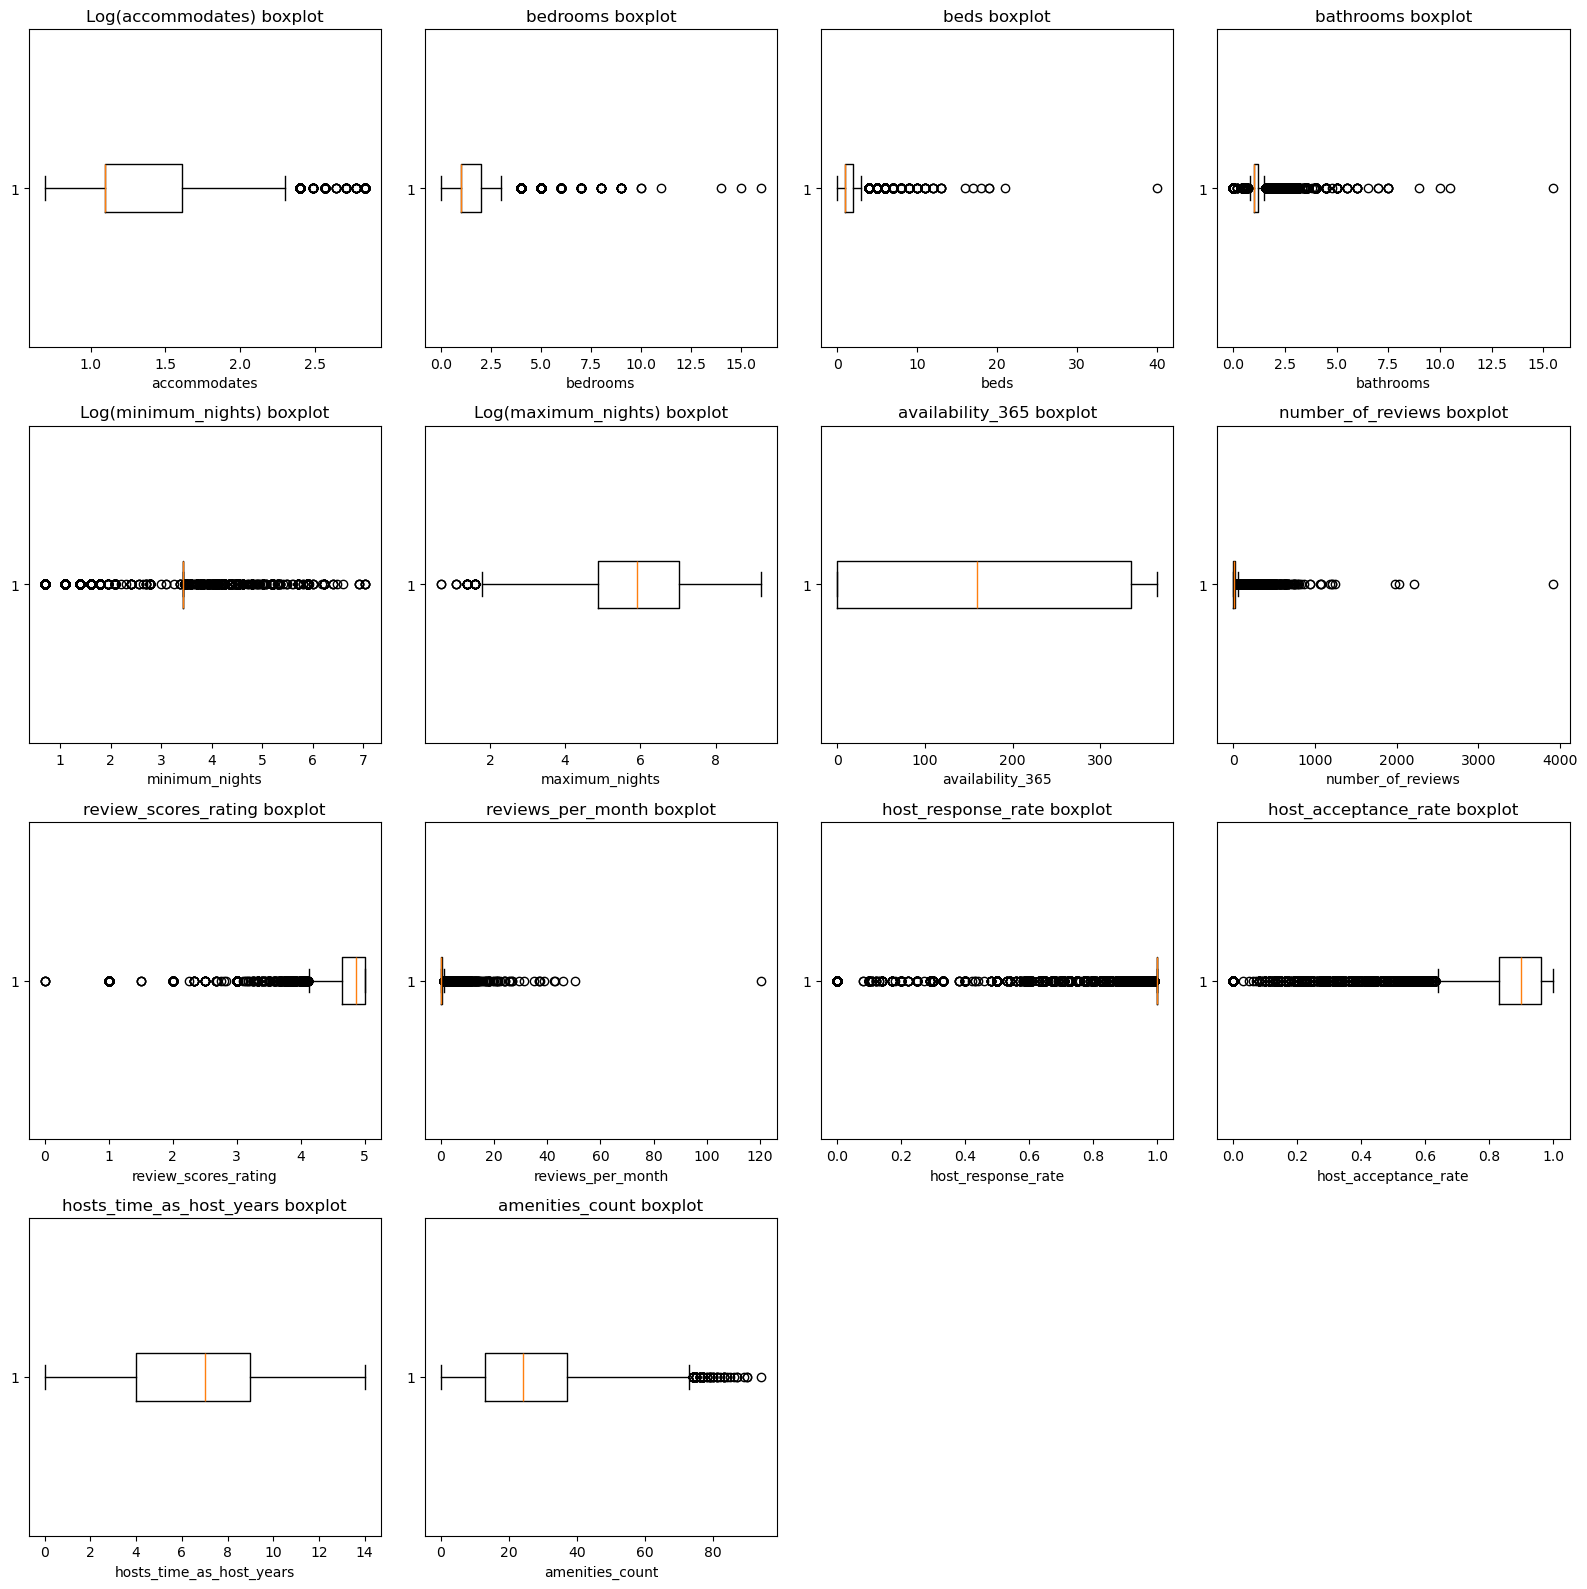

In [50]:
# 5. box plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(plot_num_cols):
    data = df_eda[col].dropna()
    if data.min() > 0 and data.skew() > 1:
        data = np.log1p(data)
        axes[i].set_title(f'Log({col}) boxplot')
    else:
        axes[i].set_title(f'{col} boxplot')
    axes[i].boxplot(data, vert=False)
    axes[i].set_xlabel(col)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

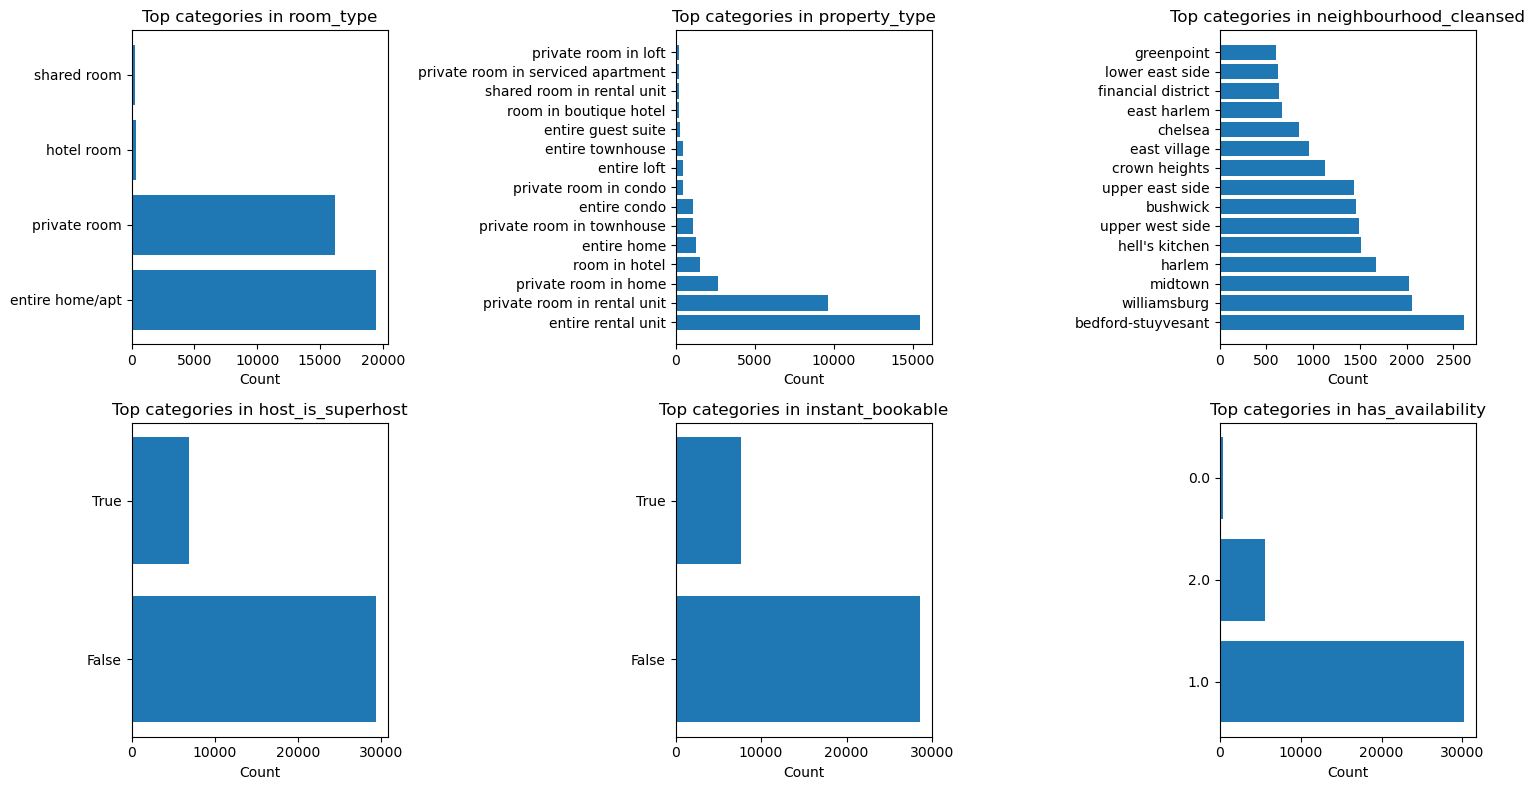

In [51]:
# 6. barchart
cat_plot_cols = ['room_type', 'property_type', 'neighbourhood_cleansed', 
                 'host_is_superhost', 'instant_bookable', 'has_availability']
cat_plot_cols = [c for c in cat_plot_cols if c in df_eda.columns]

n_cols = 3
n_rows = (len(cat_plot_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_plot_cols):
    counts = df_eda[col].value_counts().head(15)
    axes[i].barh(counts.index.astype(str), counts.values)
    axes[i].set_title(f'Top categories in {col}')
    axes[i].set_xlabel('Count')
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

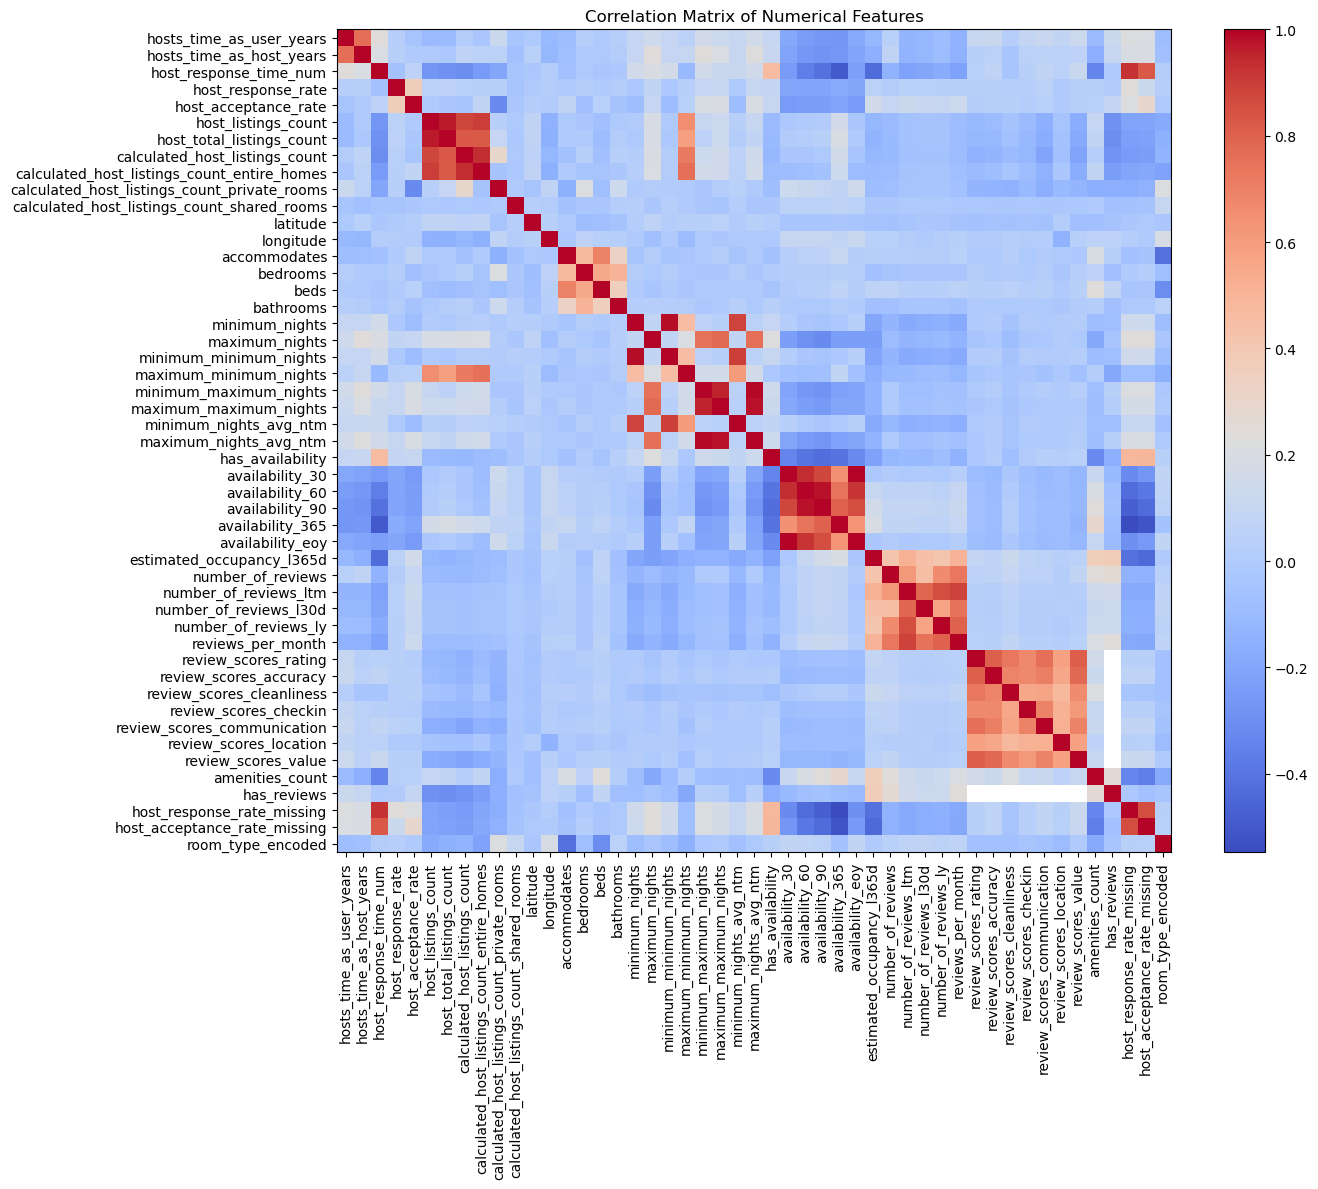


与 review_scores_rating 相关性最高的前10个变量:
 review_scores_value            0.811867
review_scores_accuracy         0.802834
review_scores_communication    0.752334
review_scores_cleanliness      0.729276
review_scores_checkin          0.673491
review_scores_location         0.582147
amenities_count                0.164006
hosts_time_as_user_years       0.105555
estimated_occupancy_l365d      0.088091
number_of_reviews              0.061038
Name: review_scores_rating, dtype: float64


In [52]:
# 7. correlation matrix heatmap
if len(num_cols) > 0:
    corr = df_eda[num_cols].corr()
    plt.figure(figsize=(14, 12))
    plt.imshow(corr, cmap='coolwarm', aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

    # correlation with review_scores_rating
    if 'review_scores_rating' in corr.columns:
        target_corr = corr['review_scores_rating'].sort_values(ascending=False)
        print("\n与 review_scores_rating 相关性最高的前10个变量:\n", target_corr.head(11)[1:])

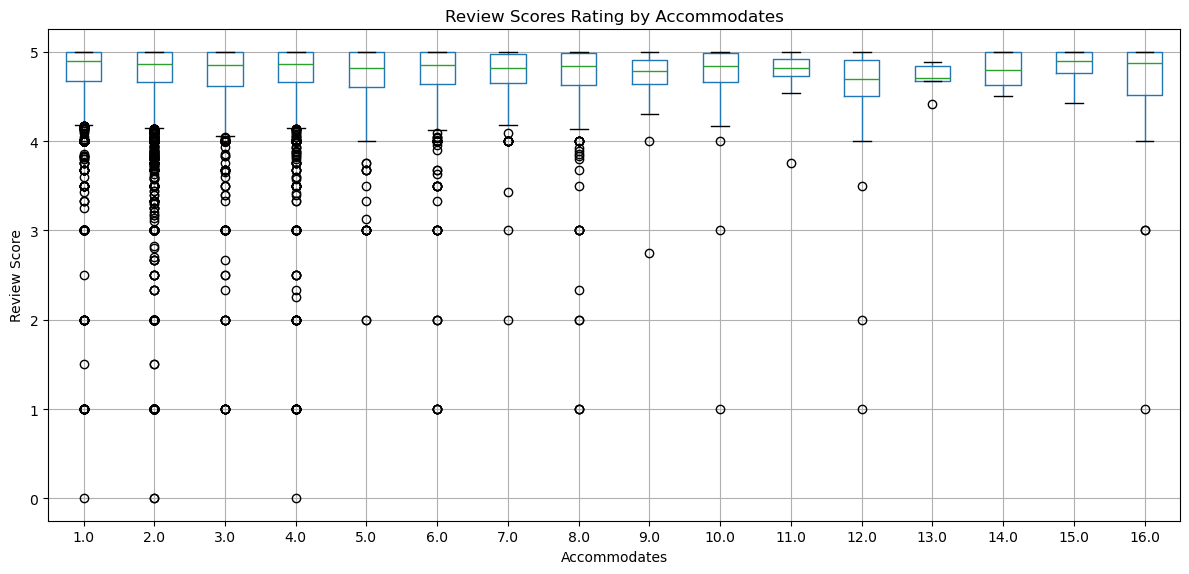

In [53]:
# 8. two variable exploration
if 'review_scores_rating' in df_eda.columns and 'accommodates' in df_eda.columns:
    
    df_eda.boxplot(column='review_scores_rating', by='accommodates', figsize=(12, 6))
    plt.title('Review Scores Rating by Accommodates')
    plt.suptitle('')
    plt.xlabel('Accommodates')
    plt.ylabel('Review Score')
    plt.tight_layout()
    plt.show()

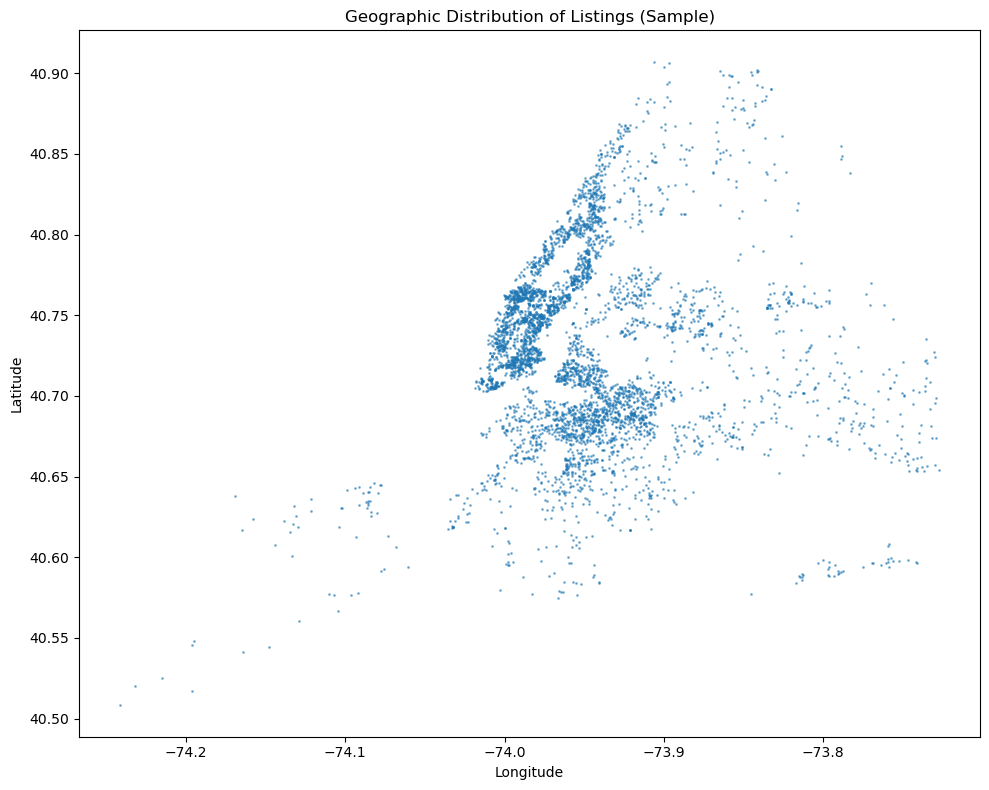

In [57]:
# 9. 地理分布
if 'latitude' in df_eda.columns and 'longitude' in df_eda.columns:
    sample = df_eda.sample(min(5000, len(df_eda)), random_state=42)
    plt.figure(figsize=(10, 8))
    plt.scatter(sample['longitude'], sample['latitude'], alpha=0.5, s=1)
    plt.title('Geographic Distribution of Listings (Sample)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

Summary: First, print the basic information of the dataset, including the number of rows and columns, the first 5 rows, all column names, and the count of each data type. This is to quickly view the overall size. Second, I compute descriptive statistics for all numerical columns (num_cols), including mean, standard deviation, minimum, quartiles, and maximum. This helps to understand the range, central tendency, and dispersion of each numerical feature, and to detect possible outliers. Third, I calculate the count and percentage of missing values for each column, filter columns with missing data, and sort them by missing percentage in descending order. Then I plot a horizontal bar chart to visually display the missing rate for each column. Forth, I select a set of representative numerical variables and plot histograms (30 bins) for each. Histograms reveal the distribution shape (e.g., normal, skewed, bimodal), central tendency, and possible outliers. Observing the distributions provides a basis for subsequent modeling or transformations (e.g., log transformation). Fifth, Drawing boxplots for the same numerical variables. For variables that are right‑skewed and have all positive values, apply natural logarithm (np.log1p) before plotting. Boxplots intuitively show the median, interquartile range, and outliers. Logarithmic transformation makes skewed distributions more symmetric, facilitating outlier identification and understanding the concentrated range of data.Sixth, it is important to select several important categorical variables, count the frequency of each category, and display the top 15 categories (if applicable) in horizontal bar charts. This quickly reveals the balance of category distributions and provides references for potential category merging or encoding later. The 7th step is to compute the correlation coefficient matrix among all numerical variables and plot a heatmap using imshow. The color intensity indicates the strength of correlation, allowing intuitive discovery of linear relationships between variables. The 8th step is to use boxplots to show the distribution of review scores (review_scores_rating) for different numbers of accommodates. Boxplots compare medians, dispersion, and outliers across groups, helping to explore whether there is a relationship between accommodates and ratings (e.g., whether more accommodates lead to lower ratings). This grouped visualization helps uncover potential patterns. The last step is geographic distribution. Since too many latitude/longitude points can make the plot overcrowded, we can randomly sample up to 5000 observations and use a scatter plot to show the geographic locations of listings (longitude on x‑axis, latitude on y‑axis). This reveals whether listings are concentrated in certain areas or if outliers exist.

# Step 4 - Data Preprocessing and Feature Engineering

Step 4 of the project was done by Jiahao & Jiarong.